In [1]:
# Import necessary libraries
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import seaborn as sns
import random
import sys

sys.path.append("../")
from structural_probes import RESULTS_DIR

# Set plot style
sns.set(style="whitegrid")

# Define model list and labels
models = ["gpt2small", "gpt2medium", "bertbase", "bertlarge"]
model_labels = ["GPT-2 small", "GPT-2 medium", "BERT-base", "BERT-large"]
dep_order = {
    "root": -1,
    "nsubj": 0,
    "dobj": 1,
    "prep": 2,
    "attr": 1,
}

# Define experiment prefix
experiment_prefix = "wikitext103_single_clause_0.1_50K_cumulative"  # Replace with actual experiment name if needed

# Set flags
include_descendants = True  # Set to True or False as needed
target_test_set = "test"    # Change to another set if needed


# Function to load results
def load_results(experiment_name, include_descendants, target_test_set):
    file_name = f"{target_test_set}_results_list{'' if include_descendants else '_no_descendants'}.pkl"
    with open(RESULTS_DIR / experiment_name / file_name, "rb") as f:
        return pickle.load(f)


# Function to calculate expected layer
def calculate_expected_layer(losses, ignore_minus_delta=True, higher_better=False):
    deltas = [
        losses[i + 1] - losses[i] if higher_better else losses[i] - losses[i + 1]
        for i in range(len(losses) - 1)
    ]
    if ignore_minus_delta:
        deltas = [d if d >= 0 else 0 for d in deltas]
    expected_layer = np.sum([deltas[i] * (i + 1) for i in range(len(deltas))]) / np.sum(
        deltas
    )
    return expected_layer


# Function to process experiment results
def process_experiment(experiment_name, include_descendants, target_test_set):
    print(f"\nProcessing experiment: {experiment_name}")
    results_list = load_results(experiment_name, include_descendants, target_test_set)
    grouped_results = defaultdict(lambda: [[] for _ in range(len(results_list))])
    MIN_OBSERVATIONS = 0  # Minimum number of observations (change if needed)

    for layer_index, layer_results in enumerate(results_list):
        for obs in layer_results:
            structure_keys = frozenset(obs["mean_metrics_by_structure"].keys())
            grouped_results[structure_keys][layer_index].append(obs)

    filtered_grouped_results = {
        k: v
        for k, v in grouped_results.items()
        if sum(len(layer_obs) for layer_obs in v) / len(results_list)
        >= MIN_OBSERVATIONS
    }

    filtered_grouped_results = dict(
        sorted(
            filtered_grouped_results.items(),
            key=lambda x: sum(len(layer_obs) for layer_obs in x[1]),
            reverse=True,
        )
    )

    structure_results = {}
    for structure_set, layer_observations in filtered_grouped_results.items():
        structure_results_list = []
        for layer, observations in enumerate(layer_observations):
            layer_result = []
            for obs in observations:
                layer_result.append(
                    {
                        "observation_index": obs["observation_index"],
                        "sentence": obs["sentence"],
                        "mean_metrics_by_structure": obs["mean_metrics_by_structure"],
                    }
                )
            structure_results_list.append(layer_result)
        structure_results[structure_set] = structure_results_list

    model_name = experiment_name.split("_")[-1]

    # Calculate metrics
    structure_expected_layers = {}
    metric = "uuas"  # Use only the UUAS metric

    grouped_results = structure_results  # Unify terminology

    all_structure_expected_layers = {}
    for structure_set, layer_observations in grouped_results.items():
        n_layers = len(layer_observations)
        structure_data = defaultdict(lambda: defaultdict(list))

        for layer, observations in enumerate(layer_observations):
            for obs in observations:
                for structure, metric_values in obs[
                    "mean_metrics_by_structure"
                ].items():
                    if metric in metric_values and metric_values[metric] is not None:
                        value = metric_values[metric]
                        structure_data[layer][structure].append(value)

        df_data = []

        for layer, structures in structure_data.items():
            for structure, values in structures.items():
                df_data.append(
                    {
                        "Layer": layer,
                        "Type": "Structure",
                        "Key": structure,
                        "Value": values,
                    }
                )

        structures_in_set = set()
        for item in df_data:
            structures_in_set.add(item["Key"])

        structure_expected_layers = {}
        for structure in structures_in_set:
            structure_data_entries = [
                entry for entry in df_data if entry["Key"] == structure
            ]
            layer_values = [np.mean(entry["Value"]) for entry in structure_data_entries]
            if len(layer_values) == 0:
                continue
            # Calculate expected layer
            expected_layer = calculate_expected_layer(
                layer_values, ignore_minus_delta=True, higher_better=True
            )

            structure_expected_layers[structure] = {
                "mean": expected_layer,
                "variance": np.var(layer_values),
            }

        all_structure_expected_layers[structure_set] = structure_expected_layers

    return all_structure_expected_layers


# Build all_results dictionary
all_results = {}

for model in models:
    experiment_name = f"{experiment_prefix}_{model}"
    structure_expected_layers = process_experiment(
        experiment_name, include_descendants, target_test_set
    )
    # Add data to all_results
    all_results[model] = {"uuas": structure_expected_layers}


Processing experiment: wikitext103_single_clause_0.1_50K_fixed_cumulative_gpt2small

Processing experiment: wikitext103_single_clause_0.1_50K_fixed_cumulative_gpt2medium

Processing experiment: wikitext103_single_clause_0.1_50K_fixed_cumulative_bertbase

Processing experiment: wikitext103_single_clause_0.1_50K_fixed_cumulative_bertlarge


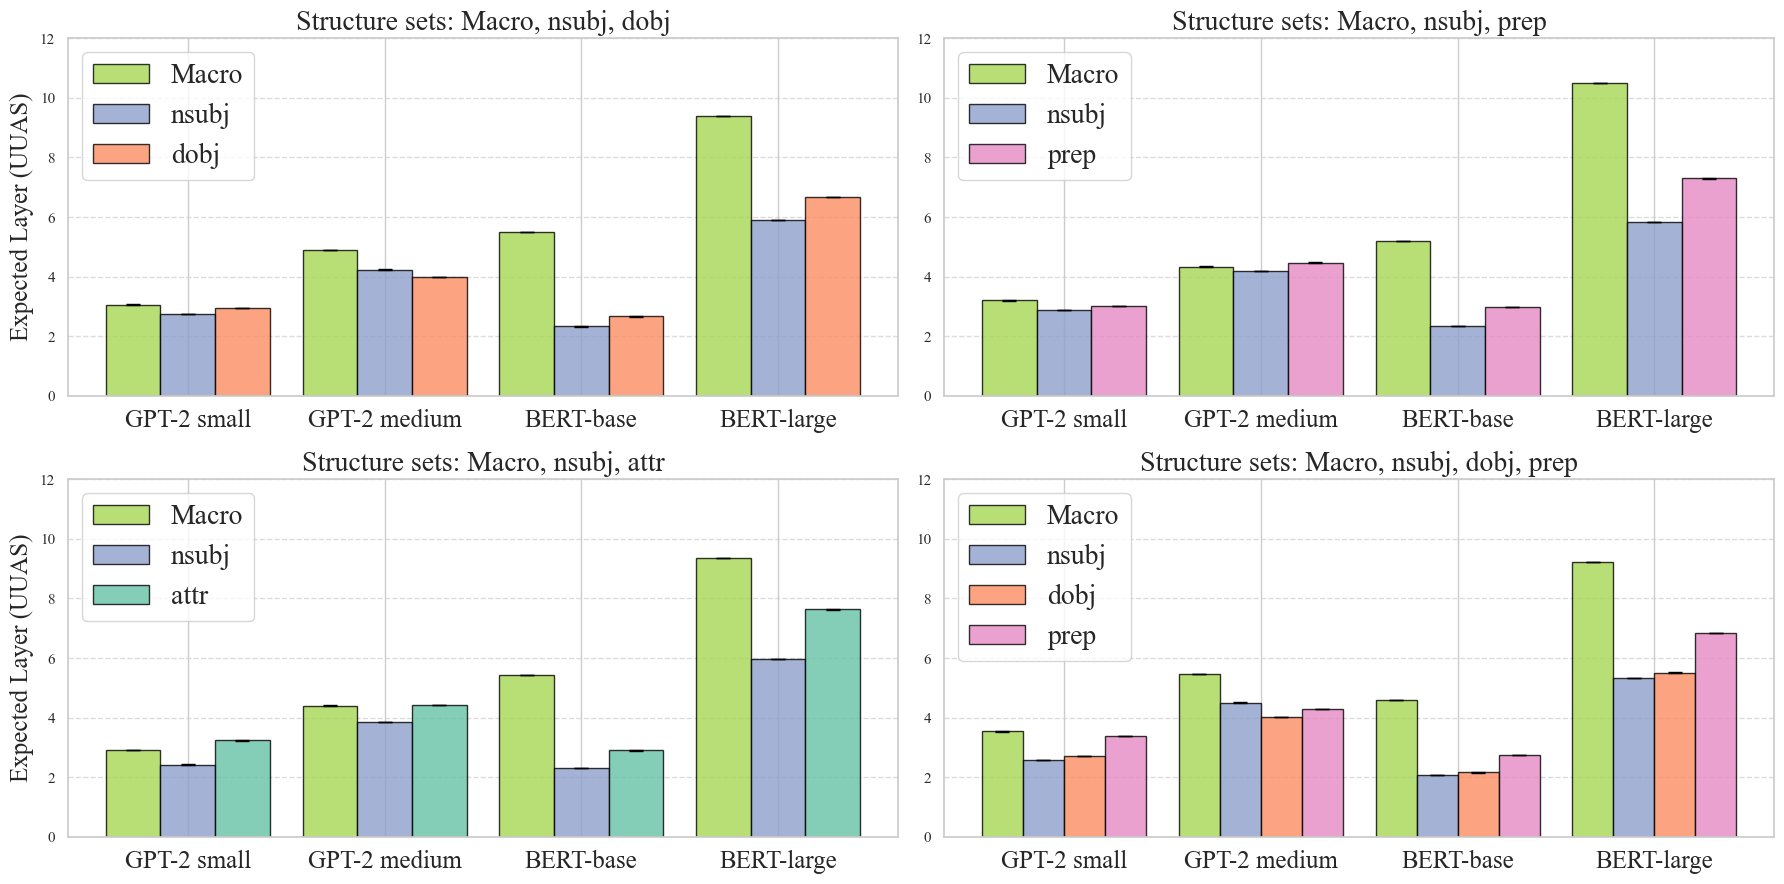

In [2]:
# Set font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

def plot_expected_layers_by_structure_set(all_results, models):
    """
    Plot expected layers by structure set for each model.

    Args:
        all_results (dict): Dictionary containing results for each model.
        models (list): List of model names.

    Returns:
        dict: Mapping from structure name to color used in the plot.
    """
    metric = "uuas"  # Only use UUAS metric
    structure_sets = list(all_results[models[0]][metric].keys())
    num_plots = len(structure_sets)
    num_cols = 2
    num_rows = 2  # Arrange subplots in a 2x2 grid

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 9))
    axes = axes.flatten()

    # Set up a unified color palette for all structures
    all_structures = set()
    for model in models:
        for struct_set in all_results[model][metric].keys():
            all_structures.update(struct_set)
    palette = sns.color_palette("Set2", n_colors=len(all_structures))
    structure_colors = dict(zip(sorted(all_structures), palette))

    for idx, structure_set in enumerate(structure_sets):
        if idx >= num_rows * num_cols:
            break  # Stop if exceeding the number of subplots
        ax = axes[idx]
        structures = sorted(list(structure_set))

        x = np.arange(len(models)) * 0.6
        total_width = 0.5
        num_structures = len(structures)
        bar_width = total_width / num_structures
        structures.sort(key=lambda x: dep_order.get(x, 100))
        for s_idx, structure in enumerate(structures):
            expected_layers = []
            variances = []
            for model in models:
                model_results = all_results[model][metric]
                mean_value = None
                variance_value = None
                if structure_set in model_results:
                    if structure in model_results[structure_set]:
                        data = model_results[structure_set][structure]
                        mean_value = data["mean"]
                        variance_value = data["variance"]
                if mean_value is not None:
                    expected_layers.append(mean_value)
                    variances.append(variance_value)
                else:
                    expected_layers.append(0)
                    variances.append(0)
            offset = (s_idx - (num_structures - 1) / 2) * bar_width
            positions = x + offset

            ax.bar(
                positions,
                expected_layers,
                yerr=variances,
                width=bar_width,
                label=structure if structure != "root" else "Macro",
                color=structure_colors[structure],
                alpha=0.8,
                capsize=5,
                edgecolor="black",
                error_kw=dict(elinewidth=1, ecolor="black"),
            )

        ax.set_xticks(x)
        ax.set_xticklabels(model_labels, fontsize=18)

        if idx % num_cols == 0:
            ax.set_ylabel("Expected Layer (UUAS)", fontsize=18)
        else:
            ax.set_ylabel("")

        # Set subplot title to the names of the structures in the set
        titles = structures.copy()
        if "root" in titles:
            titles.remove("root")  # Do not include "Macro" in the title
        titles.sort(key=lambda x: dep_order.get(x, 100))
        titles.insert(0, "Macro")
        ax.set_title(f"Structure sets: {', '.join(titles)}", fontsize=20)
        ax.set_ylim(0, 12)
        ax.grid(axis="y", linestyle="--", alpha=0.7)
        ax.legend(fontsize=20, loc="upper left")
        ax.set_yticks(np.arange(0, 13, 2))

    # Remove unused subplots
    for i in range(num_plots, num_rows * num_cols):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()
    return structure_colors

# Generate and display the plot
structure_colors = plot_expected_layers_by_structure_set(all_results, models)

## global UUAS


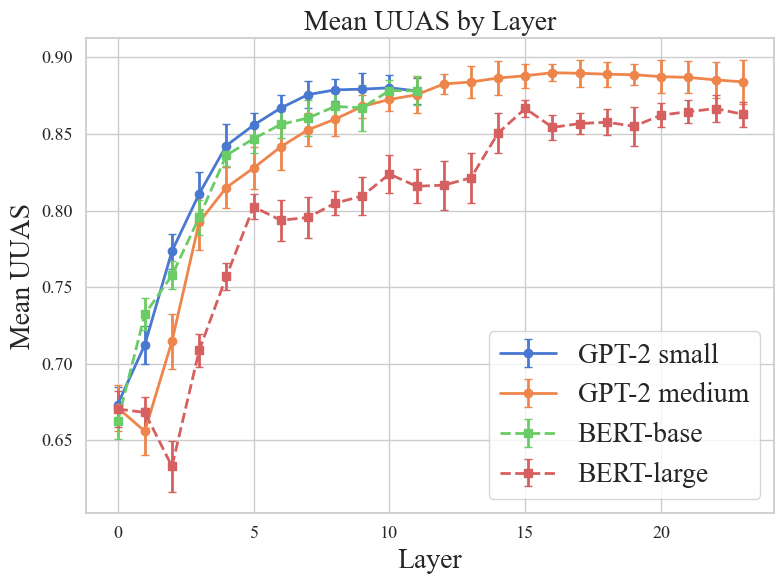

In [5]:
# Import necessary libraries

import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import seaborn as sns
import sys

sys.path.append("../")
from structural_probes import PROJECT_DIR

# Set plot style
sns.set(style="whitegrid")
plt.rcParams["font.family"] = "Times New Roman"

# Define model names and labels
models = ["gpt2small", "gpt2medium", "bertbase", "bertlarge"]
model_labels = ["GPT-2 small", "GPT-2 medium", "BERT-base", "BERT-large"]

# Define experiment prefix (replace with your actual experiment name if needed)
experiment_prefix = "wikitext103_single_clause_0.1_50K_cumulative"

# Set flags
include_descendants = True  # Set to True or False as needed
target_test_set = "test"    # Change to another set if needed

# Load results_list for each model
model_results = {}
for model in models:
    experiment_name = f"{experiment_prefix}_{model}"
    results_path = (
        PROJECT_DIR / f"results/{experiment_name}/{target_test_set}_results_list.pkl"
    )
    if not results_path.exists():
        print(f"File not found: {results_path}")
        continue
    with open(results_path, "rb") as f:
        results_list = pickle.load(f)
    model_results[model] = results_list

# Calculate layer-wise mean and std of global UUAS for each model
model_layer_mean_global_uuas = {}
model_layer_global_uuas_std = {}

for model, layers_results in model_results.items():
    layer_mean_global_uuas = {}
    layer_global_uuas_std = {}
    for layer_index, layer_result in enumerate(layers_results):
        global_uuas_list = [
            obs["global_uuas"] for obs in layer_result if obs["global_uuas"] is not None
        ]
        global_uuas_std_list = [
            obs["global_uuas_std"]
            for obs in layer_result
            if obs["global_uuas_std"] is not None
        ]
        mean_global_uuas = np.mean(global_uuas_list) if global_uuas_list else None
        std_global_uuas = (
            np.mean(global_uuas_std_list) if global_uuas_std_list else None
        )
        layer_mean_global_uuas[layer_index] = mean_global_uuas
        layer_global_uuas_std[layer_index] = std_global_uuas
    model_layer_mean_global_uuas[model] = layer_mean_global_uuas
    model_layer_global_uuas_std[model] = layer_global_uuas_std

# Create the plot
plt.figure(figsize=(8, 6))

# Get color palette
palette = sns.color_palette("muted", n_colors=len(models))

# Define style for each model
model_styles = {
    "gpt2small": {"color": palette[0], "marker": "o", "linestyle": "-"},
    "gpt2medium": {"color": palette[1], "marker": "o", "linestyle": "-"},
    "bertbase": {"color": palette[2], "marker": "s", "linestyle": "--"},
    "bertlarge": {"color": palette[3], "marker": "s", "linestyle": "--"},
}

for idx, model in enumerate(models):
    layer_mean_uuas = model_layer_mean_global_uuas.get(model, {})
    layer_std_uuas = model_layer_global_uuas_std.get(model, {})
    layers = sorted(layer_mean_uuas.keys())
    mean_uuas = [layer_mean_uuas[layer] for layer in layers]
    std_uuas = [layer_std_uuas[layer] for layer in layers]
    style = model_styles.get(model, {})
    plt.errorbar(
        layers,
        mean_uuas,
        yerr=std_uuas,
        label=model_labels[idx],
        color=style.get("color", None),
        marker=style.get("marker", "o"),
        linestyle=style.get("linestyle", "-"),
        linewidth=2,
        markersize=6,
        capsize=3,  # Error bar cap size
    )

plt.xlabel("Layer", fontsize=20)
plt.ylabel("Mean UUAS", fontsize=20)
plt.title("Mean UUAS by Layer", fontsize=20)
plt.legend(fontsize=20, title_fontsize=20, loc="lower right")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.show()

## Additional analysis



Processing experiment: wikitext103_single_clause_0.1_50K_fixed_cumulative_bertbase

Processing experiment: wikitext103_single_clause_0.1_50K_fixed_cumulative_bertlarge


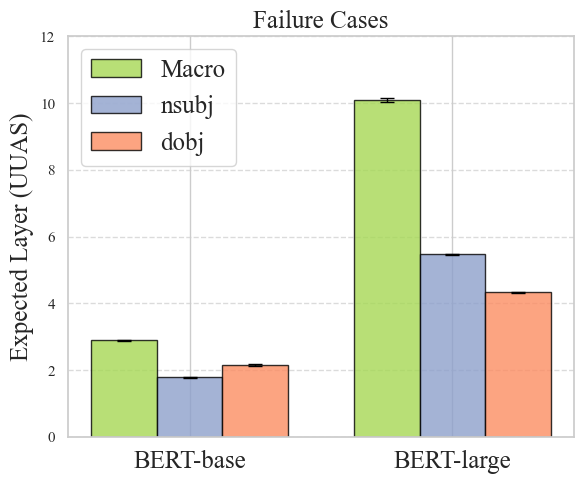

In [7]:
# Import necessary libraries
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import seaborn as sns
import random
import sys

sys.path.append("../")
from structural_probes import RESULTS_DIR

# Set plot style
sns.set(style="whitegrid")
plt.rcParams["font.family"] = "Times New Roman"

# Define model list and labels
models = ["bertbase", "bertlarge"]
model_labels = ["BERT-base", "BERT-large"]

# Define experiment prefix (replace with your actual experiment name if needed)
experiment_prefix = "wikitext103_single_clause_0.1_50K_cumulative"

# Set flags
include_descendants = True  # Set to True or False as needed
target_test_set = "prep_fixed_incorrect_whole_prob"  # Change to 'test' or other set as needed

# Function to load results
def load_results(experiment_name, include_descendants, target_test_set):
    file_name = f"{target_test_set}_results_list{'' if include_descendants else '_no_descendants'}.pkl"
    with open(RESULTS_DIR / experiment_name / file_name, "rb") as f:
        return pickle.load(f)

# Function to calculate expected layer
def calculate_expected_layer(losses, ignore_minus_delta=True, higher_better=False):
    deltas = [
        losses[i + 1] - losses[i] if higher_better else losses[i] - losses[i + 1]
        for i in range(len(losses) - 1)
    ]
    if ignore_minus_delta:
        deltas = [d if d >= 0 else 0 for d in deltas]
    if np.sum(deltas) == 0:
        return 0
    expected_layer = np.sum([deltas[i] * (i + 1) for i in range(len(deltas))]) / np.sum(deltas)
    return expected_layer

# Function to process experiment results
def process_experiment(experiment_name, include_descendants, target_test_set):
    print(f"\nProcessing experiment: {experiment_name}")
    results_list = load_results(experiment_name, include_descendants, target_test_set)
    grouped_results = defaultdict(lambda: [[] for _ in range(len(results_list))])
    MIN_OBSERVATIONS = 0  # Minimum number of observations (change if needed)

    for layer_index, layer_results in enumerate(results_list):
        for obs in layer_results:
            structure_keys = frozenset(obs["mean_metrics_by_structure"].keys())
            grouped_results[structure_keys][layer_index].append(obs)

    filtered_grouped_results = {
        k: v
        for k, v in grouped_results.items()
        if sum(len(layer_obs) for layer_obs in v) / len(results_list) >= MIN_OBSERVATIONS
    }

    filtered_grouped_results = dict(
        sorted(
            filtered_grouped_results.items(),
            key=lambda x: sum(len(layer_obs) for layer_obs in x[1]),
            reverse=True,
        )
    )

    structure_results = {}
    for structure_set, layer_observations in filtered_grouped_results.items():
        structure_results_list = []
        for layer, observations in enumerate(layer_observations):
            layer_result = []
            for obs in observations:
                layer_result.append(
                    {
                        "observation_index": obs["observation_index"],
                        "sentence": obs["sentence"],
                        "mean_metrics_by_structure": obs["mean_metrics_by_structure"],
                    }
                )
            structure_results_list.append(layer_result)
        structure_results[structure_set] = structure_results_list

    metric = "uuas"  # Only use UUAS metric

    grouped_results = structure_results  # For consistency

    all_structure_expected_layers = {}
    for structure_set, layer_observations in grouped_results.items():
        n_layers = len(layer_observations)
        structure_data = defaultdict(lambda: defaultdict(list))

        for layer, observations in enumerate(layer_observations):
            for obs in observations:
                for structure, metric_values in obs["mean_metrics_by_structure"].items():
                    if metric in metric_values and metric_values[metric] is not None:
                        value = metric_values[metric]
                        structure_data[layer][structure].append(value)

        df_data = []
        for layer, structures in structure_data.items():
            for structure, values in structures.items():
                df_data.append(
                    {
                        "Layer": layer,
                        "Type": "Structure",
                        "Key": structure,
                        "Value": values,
                    }
                )

        structures_in_set = set(item["Key"] for item in df_data)

        structure_expected_layers = {}
        for structure in structures_in_set:
            structure_data_entries = [
                entry for entry in df_data if entry["Key"] == structure
            ]
            layer_values = [np.mean(entry["Value"]) for entry in structure_data_entries]
            if len(layer_values) == 0:
                continue
            # Calculate expected layer
            expected_layer = calculate_expected_layer(
                layer_values, ignore_minus_delta=True, higher_better=True
            )
            structure_expected_layers[structure] = {
                "mean": expected_layer,
                "variance": np.var(layer_values),
            }

        all_structure_expected_layers[structure_set] = structure_expected_layers

    return all_structure_expected_layers

# Function to plot expected layers by structure set
def plot_expected_layers_by_structure_set(all_results, models, structure_colors):
    metric = "uuas"  # Only use UUAS metric
    structures = set()
    for model in models:
        for structure_set in all_results[model][metric]:
            structures.update(structure_set)
    structures = sorted(list(structures))

    x = np.arange(len(models)) * 0.4
    total_width = 0.3
    num_structures = len(structures)
    bar_width = total_width / num_structures

    fig, ax = plt.subplots(figsize=(6, 5))
    structures.sort(key=lambda x: dep_order.get(x, 100))

    for s_idx, structure in enumerate(structures):
        expected_layers = []
        variances = []
        for model in models:
            model_results = all_results[model][metric]
            mean_value = None
            variance_value = None
            for structure_set in model_results:
                if structure in model_results[structure_set]:
                    data = model_results[structure_set][structure]
                    mean_value = data["mean"]
                    variance_value = data["variance"]
                    break
            if mean_value is not None:
                expected_layers.append(mean_value)
                variances.append(variance_value)
            else:
                expected_layers.append(0)
                variances.append(0)
        offset = (s_idx - (num_structures - 1) / 2) * bar_width
        positions = x + offset

        # Plot bars
        ax.bar(
            positions,
            expected_layers,
            yerr=variances,
            width=bar_width,
            label=structure if structure != "root" else "Macro",
            color=structure_colors.get(structure, None),
            alpha=0.8,
            capsize=5,
            edgecolor="black",
            error_kw=dict(elinewidth=1, ecolor="black"),
        )

    ax.set_xticks(x)
    ax.set_xticklabels(model_labels, fontsize=18)
    ax.set_ylabel("Expected Layer (UUAS)", fontsize=18)
    title = "Failure Cases" if "incorrect" in target_test_set else "Successful Cases"
    ax.set_title(title, fontsize=18)
    ax.set_ylim(0, 12)
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.legend(fontsize=18, loc="upper left")

    plt.tight_layout()
    plt.show()

# Build all_results dictionary
all_results_tse = {}

for model in models:
    experiment_name = f"{experiment_prefix}_{model}"
    structure_expected_layers = process_experiment(
        experiment_name, include_descendants, target_test_set
    )
    all_results_tse[model] = {"uuas": structure_expected_layers}

# Generate and show plot
plot_expected_layers_by_structure_set(all_results_tse, models, structure_colors)